In [0]:
import tensorflow as tf
import tensorflow.keras.layers as layers

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
import os
import glob
import cv2

from sklearn.metrics import accuracy_score
from skimage import transform

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [0]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [0]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [0]:
d1 = x_train.shape[1]
d2 = x_train.shape[2]

In [0]:
def img_resize(img):
  img = cv2.resize(img, (d1, d2))
  img = np.array(img)
  # 色反転
  img = cv2.bitwise_not(img)
  return img

In [0]:
# ペイントで書いた数字をデータセットに追加する

paint_img = []
paint_label = []

current_path = '/content/drive/My Drive/Colab Notebooks/mnist/sample_img/'
os.chdir(current_path)

for cnt in range(10):
  print(cnt, end=' ')
  img_list = glob.glob(str(cnt) + '/*.png')

  for img in img_list:
    img = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
    img = img_resize(img)

    paint_img.append(img)
    paint_label.append(cnt)

paint_img = np.array(paint_img)
paint_label = np.array(paint_label)

print("")
print(paint_img.shape)
print(paint_label.shape)

0 1 2 3 4 5 6 7 8 9 
(500, 28, 28)
(500,)


In [0]:
# rotate
def rotate_image(images, angle):
  img_list = []
  for cnt in range(len(images)):
    img_list.append(transform.rotate(images[cnt], angle, resize=False))
  return np.array(img_list)

In [0]:
images = [paint_img]
labels = [paint_label]

# DataAugmentation
for cnt in range(3):
  images.append(rotate_image(paint_img, (cnt+1)))
  images.append(rotate_image(paint_img, -(cnt+1)))

  labels.append(paint_label)
  labels.append(paint_label)


In [0]:
# 学習データを適当に間引く
x_train = x_train[:1500]
y_train = y_train[:1500]

In [0]:
# add mnist data
images.append(x_train)
labels.append(y_train)
# 連結
x_train = np.concatenate(images, 0)
y_train = np.concatenate(labels, 0)

print(x_train.shape)
print(y_train.shape)

(5000, 28, 28)
(5000,)


In [0]:
# シャッフル
p = np.random.permutation(len(x_train))
x_train = x_train[p]
y_train = y_train[p]

In [0]:
# 各ラベルの数を確認
uni, counts = np.unique(y_train, return_counts=True)

print(uni)
print(counts)

[0 1 2 3 4 5 6 7 8 9]
[490 522 494 492 510 487 491 527 484 503]


In [0]:
unique_num = len(np.unique(y_train))
unique_num

10

In [0]:
# 0～255に変換
x_train = x_train / 255
x_test = x_test / 255

In [0]:
# OneHot
y_train = np.eye(unique_num)[y_train]
y_test = np.eye(unique_num)[y_test]

In [0]:
print(y_train.shape)
print(y_test.shape)

(5000, 10)
(10000, 10)


In [0]:
batch_size = 64
epochs = 100

kernel = 3
filters = 8

In [0]:
x_train = x_train.reshape([-1, d1, d2, 1])
x_test = x_test.reshape([-1, d1, d2, 1])

In [0]:
inputs = layers.Input(shape = (d1, d2, 1))
x = inputs

for cnt in range(2):
  filters = filters*2
  x = layers.Conv2D(filters, kernel ,padding = "SAME")(x)
  x = layers.ReLU()(x)
  x = layers.MaxPooling2D()(x)

x = layers.Flatten()(x)

x = layers.Dense(512)(x)
x = layers.ReLU()(x)
x = layers.Dropout(0.5)(x)

x = layers.Dense(64)(x)
x = layers.ReLU()(x)
x = layers.Dropout(0.5)(x)

y = layers.Dense(unique_num, activation = "softmax")(x)

model = tf.keras.Model(inputs = inputs, outputs = y)

In [0]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
re_lu (ReLU)                 (None, 28, 28, 16)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 14, 14, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0     

In [0]:
model.compile('adam', "categorical_crossentropy", metrics = ["accuracy"])

In [0]:
history = model.fit(
    x = x_train, y = y_train, 
    batch_size = batch_size,
    epochs = epochs, 
    validation_split=0.2,
    shuffle=True)

Epoch 1/100
63/63 [==============================] - 1s 10ms/step - loss: 2.1808 - accuracy: 0.1785 - val_loss: 1.8843 - val_accuracy: 0.3310
Epoch 2/100
63/63 [==============================] - 0s 5ms/step - loss: 1.8559 - accuracy: 0.3050 - val_loss: 1.6332 - val_accuracy: 0.4530
Epoch 3/100
63/63 [==============================] - 0s 5ms/step - loss: 1.6893 - accuracy: 0.3645 - val_loss: 1.5593 - val_accuracy: 0.4070
Epoch 4/100
63/63 [==============================] - 0s 5ms/step - loss: 1.5926 - accuracy: 0.4000 - val_loss: 1.5180 - val_accuracy: 0.4070
Epoch 5/100
63/63 [==============================] - 0s 5ms/step - loss: 1.5433 - accuracy: 0.4385 - val_loss: 1.4932 - val_accuracy: 0.4810
Epoch 6/100
63/63 [==============================] - 0s 5ms/step - loss: 1.4956 - accuracy: 0.4440 - val_loss: 1.4907 - val_accuracy: 0.4730
Epoch 7/100
63/63 [==============================] - 0s 5ms/step - loss: 1.4808 - accuracy: 0.4577 - val_loss: 1.4794 - val_accuracy: 0.6230
Epoch 8/100


In [0]:
def show_hist(history):

    # Setting Parameters
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure(figsize=(15, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'b.' ,label = 'training loss')
    plt.plot(epochs, val_loss, 'g.' , label= 'validation loss')
    plt.title('Training and Validation loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    
    plt.plot(epochs, acc, 'b.' ,label = 'training acc')
    plt.plot(epochs, val_acc, 'g.' , label= 'validation acc')
    plt.title('Training and Validation loss')
    plt.legend()

    plt.show()

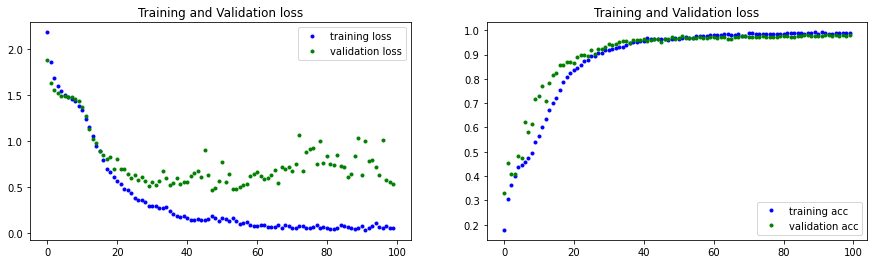

In [0]:
show_hist(history)

In [0]:
# モデル保存
current_path = '/content/drive/My Drive/Colab Notebooks/mnist/model'
os.chdir(current_path)
# model save
model.save('model_mnist.h5', include_optimizer=True)

In [0]:
# mnist testデータをテスト
pred_y = model.predict(x_test)
pred_y.shape

# dummy -> cat
pred_y = np.argmax(pred_y, axis=1)
y_test = np.argmax(y_test, axis=1)

print(accuracy_score(y_test, pred_y))

0.955


In [0]:
# ペイント画像をテスト
current_path = '/content/drive/My Drive/Colab Notebooks/mnist/test_img/'
os.chdir(current_path)

label_list = []
test_data = []

for cnt in range(10):
  print(cnt, end=" ")
  
  img_list = glob.glob(str(cnt) + '/*.png')
  img_list.sort()

  label_list.append(np.full(len(img_list), cnt))

  for img in img_list:
    img = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
    img = img_resize(img)
    test_data.append(img)

test_data = np.array(test_data)
test_data = test_data/255
test_data = test_data.reshape([-1, d1, d2, 1])

0 1 2 3 4 5 6 7 8 9 

In [0]:
y_pred = model.predict(test_data)
y_pred = np.argmax(y_pred, axis=1)
label_ans = np.concatenate(label_list)

print(accuracy_score(label_ans, y_pred))

0.98


In [0]:
y_pred

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4,
       4, 4, 4, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 8, 3, 8, 8,
       8, 9, 9, 9, 9, 9])

In [0]:
y_pred = model.predict(paint_img)
y_pred = np.argmax(y_pred, axis=1)

print(accuracy_score(paint_label, y_pred))

0.99
